# Vehicle Detection and Tracking

## 1. Overview
The goal of this project is to build a pipeline for vehicle detection and tracking. 

Before going to the main part, here we import some libraries and 
read (names of) images to be used throughout this project:

In [1]:
### import libraries

import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob 
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import time 
from sklearn.svm import LinearSVC
%matplotlib inline

In [2]:
### Read images 

# vehicle and non-vehicle images for training and validating detection model 
vehicle_imgs = glob.glob('vehicles/**/*png', recursive=True)
non_vehicle_imgs = glob.glob('non-vehicles/**/*png', recursive=True)

### read file names of the road images in test_images folder
test_imgs = glob.glob('test_images/*jpg')

# size of an road image in test_images is 1280x720 with 3 color channel 
img_size = plt.imread(test_imgs[0]).shape[:2]

number of vehicle images: 8792
number of  non-vehicle images: 8968
size of vehicle/non-vehicle images: (64, 64, 3)


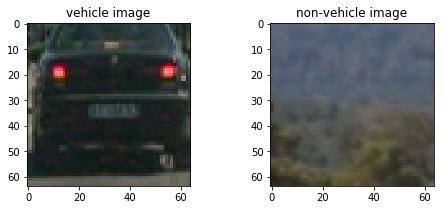

size of test image of a road: (720, 1280, 3)


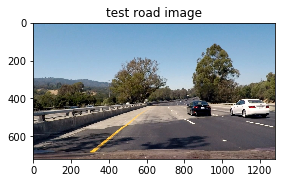

In [3]:
### for visualization

# check the number of the vehicle/non-vehicle images (-> they are almost the same)
print('number of vehicle images:', len(vehicle_imgs))
print('number of  non-vehicle images:', len(non_vehicle_imgs))

# examples of vehicle/non-vehicle images
v_ind = np.random.randint(0, len(vehicle_imgs))
v_img = mpimg.imread(vehicle_imgs[v_ind])
nv_ind = np.random.randint(0, len(non_vehicle_imgs))
nv_img = mpimg.imread(non_vehicle_imgs[nv_ind])

# examples of a road image 
test_ind = np.random.randint(0, len(test_imgs))
test_img  = mpimg.imread(test_imgs[test_ind])

print('size of vehicle/non-vehicle images:', v_img.shape)

# plot
fig = plt.figure(figsize = (8, 3))
plt.subplot(121)
plt.imshow(v_img)
plt.title('vehicle image')
plt.subplot(122)
plt.imshow(nv_img)
plt.title('non-vehicle image')
# plt.savefig('output_images/vehicle_non_vehicle.jpg')
plt.show()

print('size of test image of a road:', test_img.shape)

fig = plt.figure(figsize = (8, 2.5))
plt.title('test road image')
plt.imshow(test_img)
# plt.savefig('output_images/road.jpg')
plt.show()

## 2. Feature Extraction and Model Building

In this part, we start with extracting features by combining three methods (histogram of oriented gradients, 
histogram of color, spatial binning of color). We then use this  to create training and test data sets from the images 
of the vehicle and non-vehicles. After this, we build a model for classifying (non-)vehicles by using 
the support vector machine algorithm. We note that, since we 
combine three feature extraction methods and thus the value of the features can vary a lot, 
the normalization of the feature vector is needed when we create the training and test set 
from the images of the vehicles and non-vehicles. 

### 2.1. Feature Extraction

We first extract the features from a given image. 
Here we introduce the three methods for the feature extraction that we use for this project.
We combine them to build our pipeline for the feature extraction. 

#### 2.1.1. Feature Extraction with Histogram of Oriented Gradients (HOG)

We first define the function `get_hog_features()` which extracts features by using histogram of 
oriented gradients (HOG):

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    This function uses hog() of skimage to extract hog features. 
    If vis = True/False features and image/only features are returned. 
    
    NOTE
    orient: the number of orientations for HOG
    pix_per_cell: the number of pixels per cell in row/column
    cell_per_block: the number of cells per block in row/column
    '''
    if vis == True: 
        hog_features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                        cells_per_block=(cell_per_block, cell_per_block), visualise=vis, 
                                          feature_vector=feature_vec, block_norm="L2-Hys", transform_sqrt=True)
        return hog_features, hog_image
    
    else: 
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                        cells_per_block=(cell_per_block, cell_per_block), visualise=vis, 
                                          feature_vector=feature_vec, block_norm="L2-Hys", transform_sqrt=True)
        return hog_features
    

An example of HOG obtained by applying this function is given below (Since we use YCrCb color space
for model building, in the following examples, we use the images converted to YCrCb space):

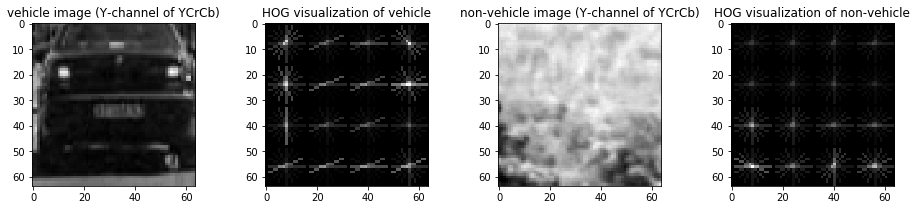

In [5]:
### for visualization

# # comment ouf the following part if one wants to consider new vehicle/non-vehicle images
# v_ind = np.random.randint(0, len(vehicle_imgs))
# v_img = mpimg.imread(vehicle_imgs[v_ind])
# nv_ind = np.random.randint(0, len(non_vehicle_imgs))
# nv_img = mpimg.imread(non_vehicle_imgs[nv_ind])

# Y-channel image of (non-)vehicle in YCrCb color space
v_y = cv2.cvtColor(v_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
nv_y = cv2.cvtColor(nv_img, cv2.COLOR_RGB2YCrCb)[:,:,0]

# parameters for HOG feature extraction 
orient = 8 # number of orientation  
pix_per_cell = 16 # number of pixels per cell
cell_per_block = 2 # nubmer of cells per block
 
# apply HOG feature extraction 
v_features, v_hog_image=get_hog_features(v_y, orient= orient, pix_per_cell= pix_per_cell, 
                                             cell_per_block= cell_per_block, vis=True, feature_vec=False)
nv_features, nv_hog_image=get_hog_features(nv_y, orient= orient, pix_per_cell= pix_per_cell, 
                                             cell_per_block= cell_per_block, vis=True, feature_vec=False)

# plot original and hog images
fig = plt.figure(figsize = (16, 3))
plt.subplot(141)
plt.imshow(v_y, cmap='gray')
plt.title('vehicle image (Y-channel of YCrCb)')
plt.subplot(142)
plt.imshow(v_hog_image, cmap='gray')
plt.title('HOG visualization of vehicle')
plt.subplot(143)
plt.imshow(nv_y, cmap='gray')
plt.title('non-vehicle image (Y-channel of YCrCb)')
plt.subplot(144)
plt.imshow(nv_hog_image, cmap='gray')
plt.title('HOG visualization of non-vehicle')
# plt.savefig('output_images/hog.jpg')
plt.show()

#### 2.1.2. Feature Extraction with Histogram of Color

Here we use the histogram of color to extract features. For this purpose, we define 
the function `color_hist()` as follow:

In [6]:
def color_hist(image, hist_bins = 16, bins_range=(0, 256)):
    """
    This function creates features from histogram of color
    by binning each channel into hist_bins bins. 
    
    """
    # if entries of the array for image takes values in [0,1], then 
    # rescale such that they take value in range [0, 255]
    img = image.copy()
    if img.dtype != np.uint8:
        img = (255*img).astype(np.uint8)
    
    # create a histogram of each color channels
    ch1_hist = np.histogram(img[:,:,0], bins=hist_bins, range=bins_range)
    ch2_hist = np.histogram(img[:,:,1], bins=hist_bins, range=bins_range)
    ch3_hist = np.histogram(img[:,:,2], bins=hist_bins, range=bins_range)
    
    # concatenate into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))

    # compute the center locations of bins (used for the visualization)
    bin_edges = ch1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    return ch1_hist, ch2_hist, ch3_hist, bin_centers, hist_features 


An example of the histograms of color obtained by applying `color_hist()` is given below:

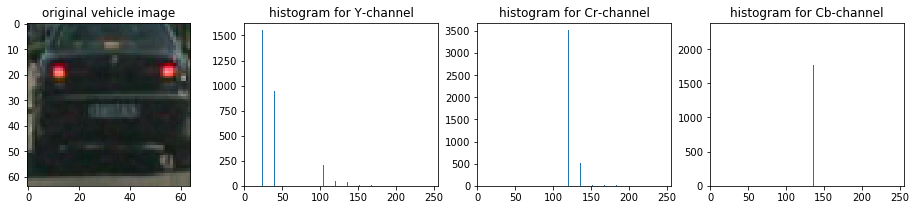

In [7]:
### for visualization

# # comment ouf the following part if one wants to consider a new vehicle image
# v_ind = np.random.randint(0, len(vehicle_imgs))
# v_img = mpimg.imread(vehicle_imgs[v_ind])

# parameters for feature extraction with color histograms
hist_bins = 16 # number of bins 
bins_range=(0, 256) # the range of bins 

# use YCrCb color space
v_img_ycrcb = cv2.cvtColor(v_img, cv2.COLOR_RGB2YCrCb)
# extract feature by using color histogram
ch1_hist, ch2_hist, ch3_hist, bin_centers, hist_features = color_hist(v_img_ycrcb , hist_bins=hist_bins, 
                                                                                  bins_range=bins_range)

# plot original image and the histograms of color
fig = plt.figure(figsize=(16,3))
plt.subplot(141)
plt.title('original vehicle image')
plt.imshow(v_img)
plt.subplot(142)
plt.bar(bin_centers, ch1_hist[0])
plt.xlim(0, 256)
plt.title('histogram for Y-channel')
plt.subplot(143)
plt.bar(bin_centers, ch2_hist[0])
plt.xlim(0, 256)
plt.title('histogram for Cr-channel')
plt.subplot(144)
plt.bar(bin_centers, ch3_hist[0])
plt.xlim(0, 256)
plt.title('histogram for Cb-channel')
# plt.savefig('output_images/color_histogram.jpg')
plt.show()

#### 2.1.3. Feature Extraction with Spatial Binning

Here we use the spatial binning of color to extract features:

In [8]:
def bin_spatial(img, cspace_binning = None, size= (16, 16)):
    """
    this function uses spatial binning to extract features 
    cspace_binning: color space to be used 
    
    NOTE
    size: spatial size after binning 
    """
    
    # convert image to new color space (if specified)
    if cspace_binning != 'RGB':
        if cspace_binning == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace_binning == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace_binning == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace_binning == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace_binning == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_img = np.copy(img)     
        
    # the spatial binning by using cv2.resize() function and then create the feature vector
    bin_features = cv2.resize(img, size).ravel()
    
    return bin_features

An example of the features obtained by applying the spatial binnning is given below:

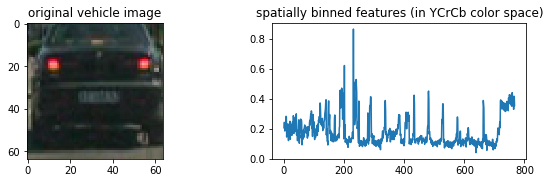

In [9]:
### for visualization

# # comment ouf the following part if one wants to consider a new vehicle image
# v_ind = np.random.randint(0, len(vehicle_imgs))
# v_img = mpimg.imread(vehicle_imgs[v_ind])

# parameters for feature extraction with spatial binning
spatial_size = (16, 16) # size after the spatial binning
cspace_binning = 'YCrCb' # the color space to be considered (unchanged here, i.e. RGB)

# use YCrCb color space
v_img_ycrcb = cv2.cvtColor(v_img, cv2.COLOR_RGB2YCrCb)
# extract features with spatial binning
bin_features = bin_spatial(v_img, cspace_binning = cspace_binning , size= spatial_size)

# plot
fig = plt.figure(figsize=(10,2.5))
plt.subplot(121)
plt.title('original vehicle image')
plt.imshow(v_img)
plt.subplot(122)
plt.plot(bin_features)
plt.title('spatially binned features (in YCrCb color space)')
# plt.savefig('output_images/spatial_binning.jpg')
plt.show()

#### 2.1.4. Combining Feature Extractions

Now we we combine the above three methods for the feature extractions to obtain a feature vector of a given image. 
This feature vector is used for buildng our classification model. 

In [10]:
def extract_features(imgs, orient, pix_per_cell, cell_per_block, hog_channel = 'ALL', cspace='YCrCb', 
                         cspace_binning=None, spatial_size=(16, 16), hist_bins=16, bins_range=(0, 256)):
    """
    This function extracts spatial features, color features and HOG features
    and then concatenate them to give a single feature vector for each image. 
    
    NOTE
    hog_channel: the color channel(s) used for HOG. 0, 1, 2 or 'All' (= use all the three channels)
    """
    
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        # convert to other color space
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 
        
        # extract HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                                         pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # extract spatial features and color features
        spatial_features = bin_spatial(feature_image, cspace_binning = cspace_binning, size=spatial_size)
        _, _, _, _, hist_features = color_hist(feature_image, hist_bins=hist_bins, bins_range=bins_range)
        
        # concatenate extracted features 
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    return features

Now we set the parameters used in `extract_features()` for this project. These parameters 
will be used when we bulid our classification model. 

In [11]:
### parameters for feature extraction

colorspace = 'YCrCb' 
colorspace_bining = None # since the image has been already converted to YCrCb before bin_spatial() is used
orient = 8
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" 
spatial_size = (16, 16)
hist_bins = 16
bin_range = (0, 256)

### 2.2. Model Building 

Once we established the way to extract features, we build a model for classifying 
the vehicle and non-vehicle images. 

We first use `extract_features()` defined above to 
create training and test sets from the downloaded vehicle and non-vehicle images.  
Since we combines the features from three different extraction methods, we normalize 
the feature vectors such that the values of the different features do not vary a lot. 
The training/test set is created as follows:

In [12]:
### Create training and test sets

# use all the images 
vehicle_imgs_samples = vehicle_imgs
non_vehicle_imgs_samples = non_vehicle_imgs

# # use this instead of the above if one wants to work with a small number of samples 
# sample_size = 5 # the number of samples 
# vehicle_imgs_samples = vehicle_imgs[0:sample_size]
# non_vehicle_imgs_samples = non_vehicle_imgs[0:sample_size]

# extract features with extract_features()
t1=time.time()
vehicle_features = extract_features(vehicle_imgs_samples, cspace=colorspace, cspace_binning=colorspace_bining,
                                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_size = spatial_size, hist_bins = hist_bins)
non_vehicle_features = extract_features(non_vehicle_imgs_samples, cspace=colorspace, cspace_binning=colorspace_bining,
                                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel, spatial_size = spatial_size, hist_bins = hist_bins)
t2 = time.time()
print(round(t2-t1, 2), 'seconds to extract features...')

# create an array stack of feature vectors and the corresponding labels vector
# label: 1 for vehicle and 0 for non-vehicle 
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features)))) 

# random shuffle and split to training and test set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# rescale the features
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('parameters for HOG:',orient,'orientations',pix_per_cell, 
              'pixels per cell and', cell_per_block,'cells per block')
print('length of feature vector:', len(X_train[0]))

131.68 seconds to extract features...
parameters for HOG: 8 orientations 16 pixels per cell and 2 cells per block
length of feature vector: 1680


Once the training and test sets are ready, we build our vehicle/non-vehicle classifier. 
We use the **Support Vector Machine (SVM) with a linear kernel** for our model. 
We denote our model by `svc`:

In [13]:
### Build a classification model 

# use SVC with a linear kernel 
svc = LinearSVC()

# train our model 
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'seconds to train our model')
print('')

# check the performance of our model
print('training accuracy of our model:', round(svc.score(X_train, y_train), 4))
print('test accuracy of our model:', round(svc.score(X_test, y_test), 4))

# predict with our model
t1=time.time()
n_predict = 10
print('predictions:', svc.predict(X_test[0:n_predict]))
print('true labels:', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'seconds to predict', n_predict,'labels with our model')

5.37 seconds to train our model

training accuracy of our model: 0.9999
test accuracy of our model: 0.9899
predictions: [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
true labels: [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
0.00256 seconds to predict 10 labels with our model


## 3. Finding Vehicles
In the previous part, we buit a classifier to judge if a given image is a vehicle or not. 
A camera equipped in front of a vehicle captures an image of a road and vehicle(s) can 
be located in a subregion of it. 
We thus need to focus on a subregion in the image, apply our classifier to 
judge if a vehicle is there or not and then repeat this for various subregions. 
Here we use the sliding window search (Hog sub-sampling window search) to do this procedure. We also 
use the heatmap to improve our pipeline for the vehicle finding. 

### 3.1.  Sliding Window Search
Here we define a function `find_vehicles()` which does the sliding window search of vehicles by using 
our classifier and returns the locations of the boxes inside which the classifier detected a vehicle. 
We also define `convert_color()` which is used for changing the color space of an image 
and `draw_boxes()` which we will use for drawing the boxes detected by `find_vehicles()` 
on the original image of a road. 

In [14]:
def convert_color(img, conv = None):
    '''
    This function can be used for changing the color space of an image. 
    '''
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else:
        return img

def find_vehicles(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                      cells_per_step = 2, 
                      spatial_size = (16, 16), hist_bins = 16, cspace = 'YCrCb', cspace_binning = None):
    """
    This function does sliding window, extracts HOG, binned color and color histogram features
    and then make prediction (if vehicle or not)
    
    NOTE
    ystart: y-coordinate of the top edge of the region to do the window seearch 
    ystop: y-coordinate of the bottom edge of the region to do the window seearch 
    scale: scale of the window
    
    """
    
    # data preprocessing: normalize, restrict search region, convert color, resize
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop, :,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # split the channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = cells_per_step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # extract HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # for each subregion, extract features and apply our classifier
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # extract HOG features for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
        
            # extract binned color features and color histogram features
            spatial_features = bin_spatial(subimg, cspace_binning = cspace_binning, size=spatial_size)
            _, _, _, _, hist_features = color_hist(subimg, hist_bins=hist_bins)

            # scale features and make a prediction
            # print(np.hstack((spatial_features, hist_features, hog_features)))
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_prediction = svc.predict(test_features)
            
            # if a vehicle is detected, draw a bounding box 
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))

                
    return box_list

def draw_boxes(img, box_list): 
    '''
    this function is used for drawing the boxes detected by find_vehicles() function 
    on the original image of a road. 
    '''
    draw_img = np.copy(img)
    for box in box_list:
        cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)
    return draw_img

We can see the performance of our sliding window search by applying to a test image of a road below. 
Here we note that we use several different windows and scanned different regions in the image 
(our choice is given in `param_find` which stores tuples of `ystart`, `ystop`, `scale` and `cells_per_step`).

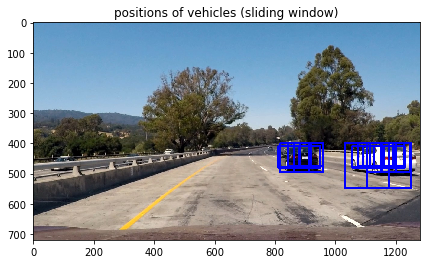

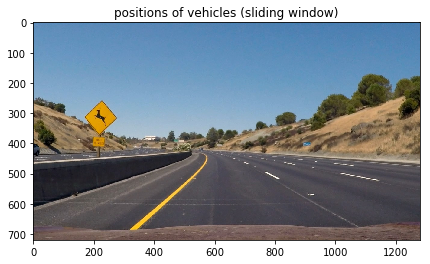

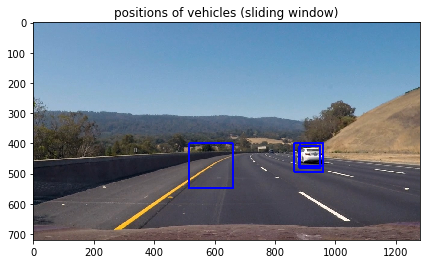

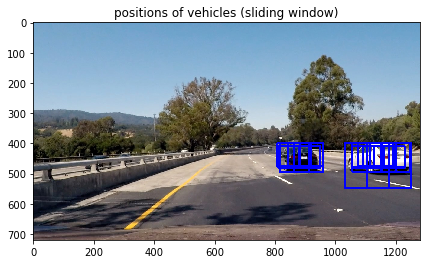

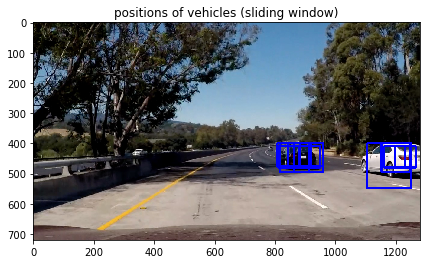

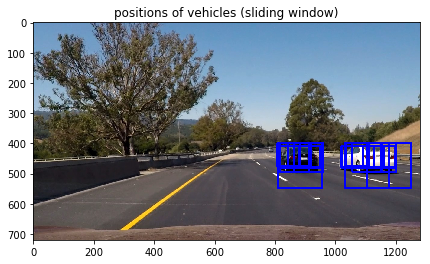

In [18]:
##### Apply sliding window search to detect vehicles 

# a set of parameters for window search 
param_find = [(400, 500, 1.5, 2), (400, 480, 1.2, 2), (400, 620, 2.3, 2), (410, 500, 1.1, 2)]

test_imgs_v = test_imgs
# # use below instead if one wants to create a image file for the write-up
# test_imgs_v = ['test_images/test4.jpg'] 

for test_img in test_imgs_v:
    img = mpimg.imread(test_img)
    box_list_total = []
    for ystart, ystop, scale, cells_per_step in param_find:
        box_list = find_vehicles(img, ystart=ystart, ystop=ystop, scale=scale, svc = svc, 
                                      X_scaler = X_scaler, orient = orient, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block, cells_per_step = cells_per_step, 
                                             spatial_size = spatial_size, hist_bins=hist_bins)
        box_list_total = box_list_total + box_list

    # add the detected boxes on the original image
    out_img = draw_boxes(img, box_list_total)

    # plot
    fig = plt.figure(figsize=(8, 4))
    plt.title('positions of vehicles (sliding window)')
    plt.imshow(out_img)
    # plt.savefig('output_images/sliding_window_test4.jpg')
    plt.show()

### 3.2. Heatmap for Finding Vehicles

To improve our pipeline for the vehicle detection, we compute the heat map which 
counts how many times a vehicle was detected in each pixel. We then impose a threshold on the value 
at each pixel of the heatmap to write down the final bounding boxes for vehicle finding. 
For this purpose, we define the following three functions:

In [19]:
def add_heat(heatmap, bbox_list):
    """
    This function updates the heatmap such that, 
    for a given pixel, if a vehicle is detected n times, then 
    the entry of the heatmap corresponding to this pixel takes value n 
    """
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    """
    this function applies a threshold to the heatmap such that, 
    if a given entry in the heatmap takes value smaller than or equal to 
    the threshold, then the entry is replaced by 0 
    """
    heat_th = heatmap.copy()
    heat_th[heat_th <= threshold] = 0
    
    return heat_th

def draw_labeled_bboxes(img, labels, thresh_a = 2500.0):
    """
    The finals location of the detected vehicles are determined by 
    applying label() function of scipy library to the output of apply_threshold().
    Based on this, this function draws the bounding boxes for the detected vehicles on a origina road image.
    A threshold on the area of bounding boxes is introduced to reduce false positives.
    """
    
    for vehicle_number in range(1, labels[1]+1):
        # find pixels with each vehicle_number label value
        nonzero = (labels[0] == vehicle_number).nonzero()
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # draw the box (with threshold on area of bounding box)
        area = (np.max(nonzerox) - np.min(nonzerox))*(np.max(nonzeroy) - np.min(nonzeroy))
        # print(area)
        if(area > thresh_a):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    return img

Now we apply these functions to create the heatmap and then draw the final bounding boxes 
for the vehicle finding:

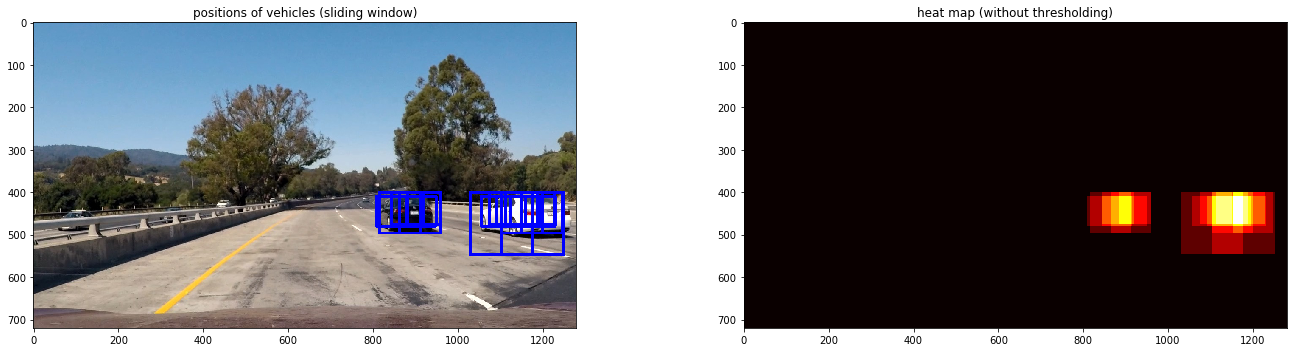

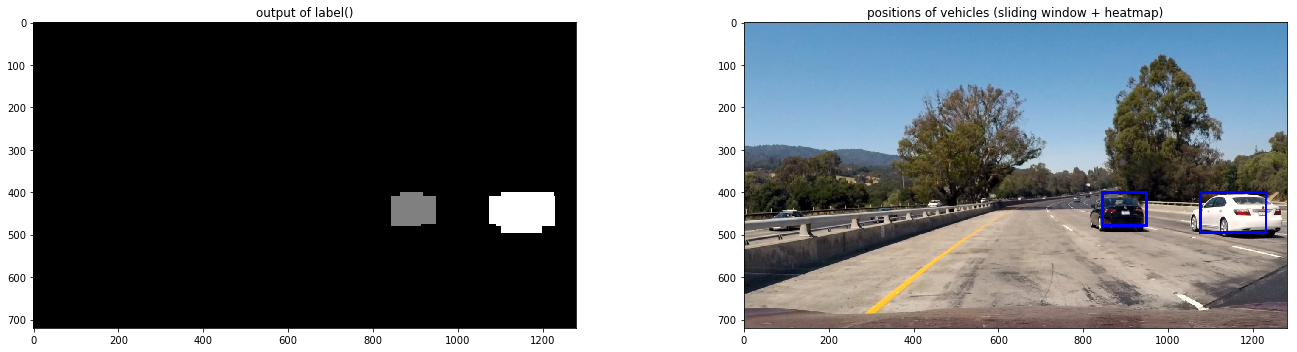

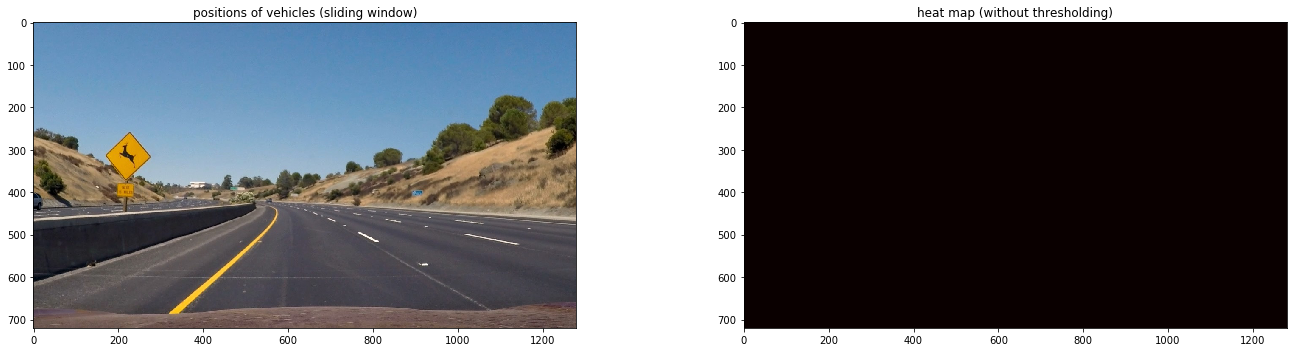

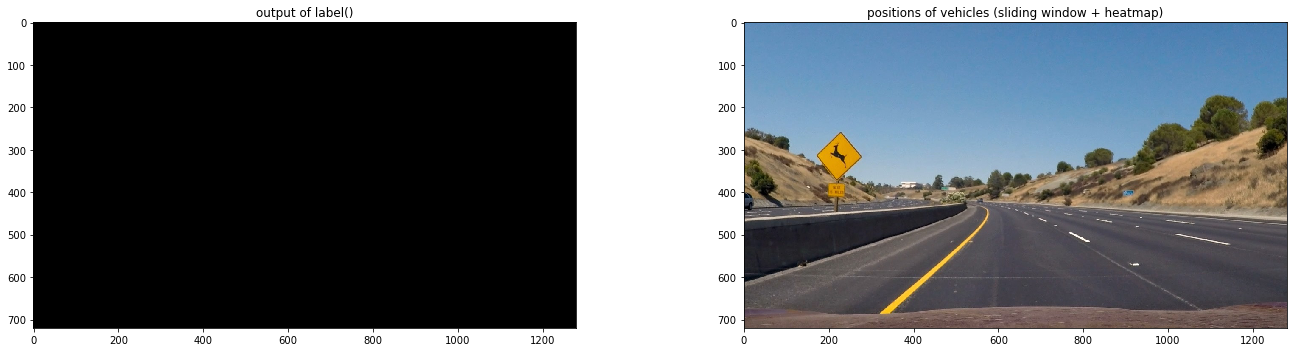

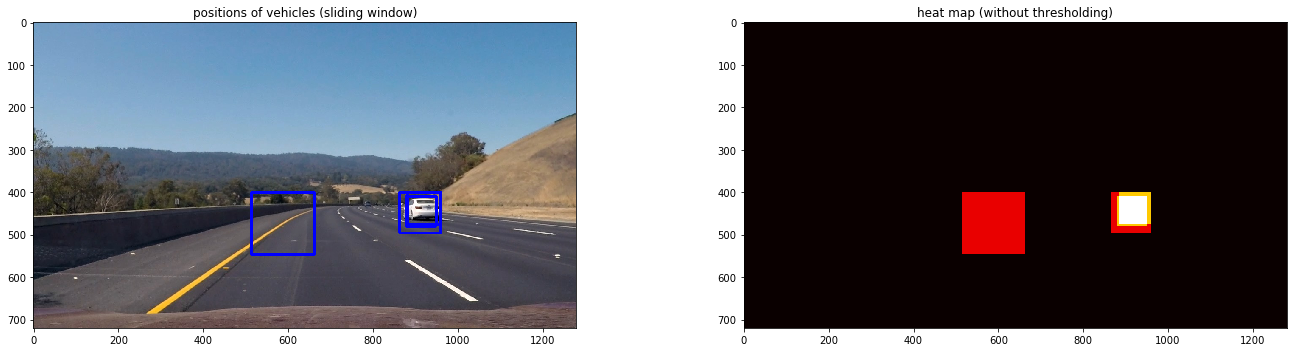

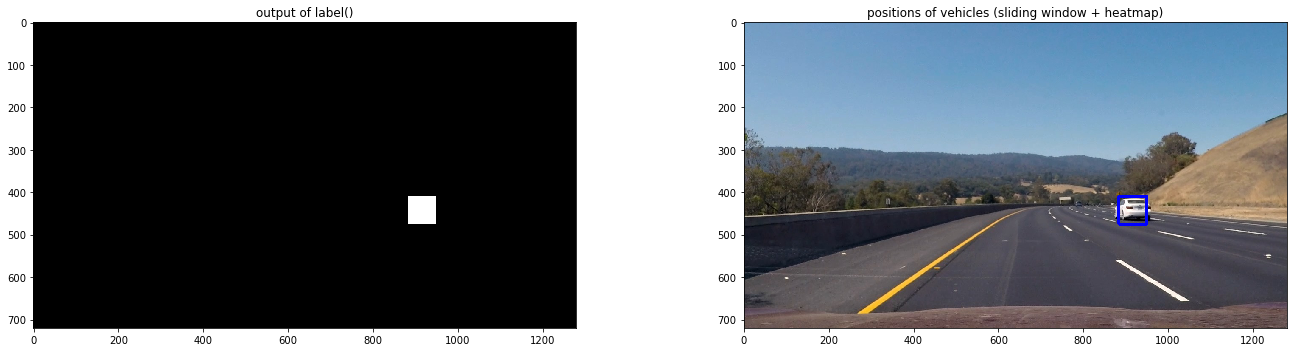

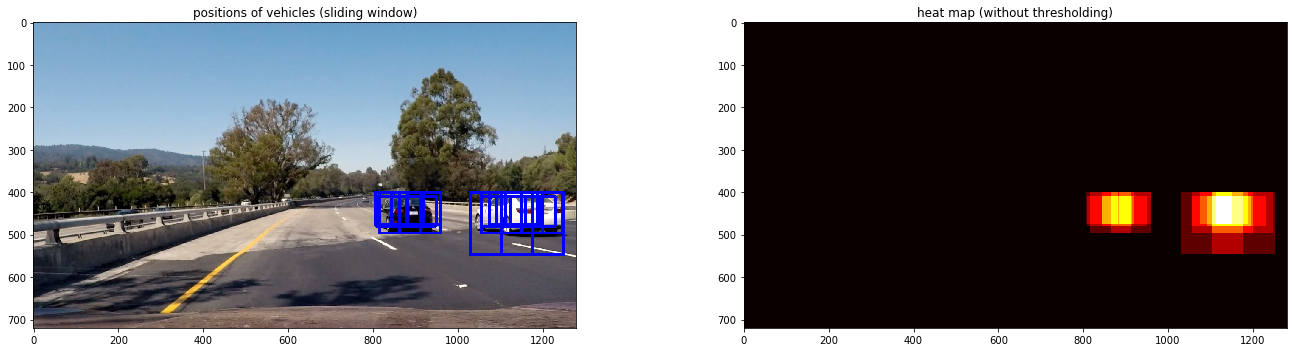

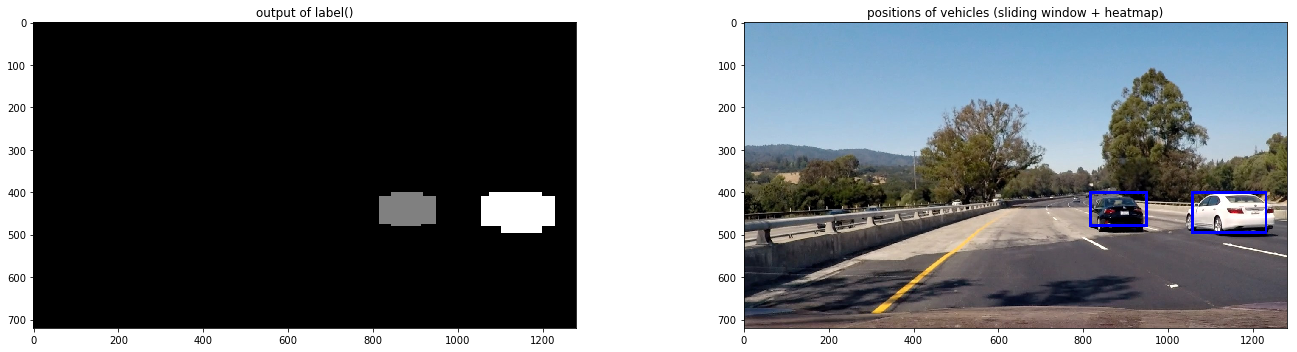

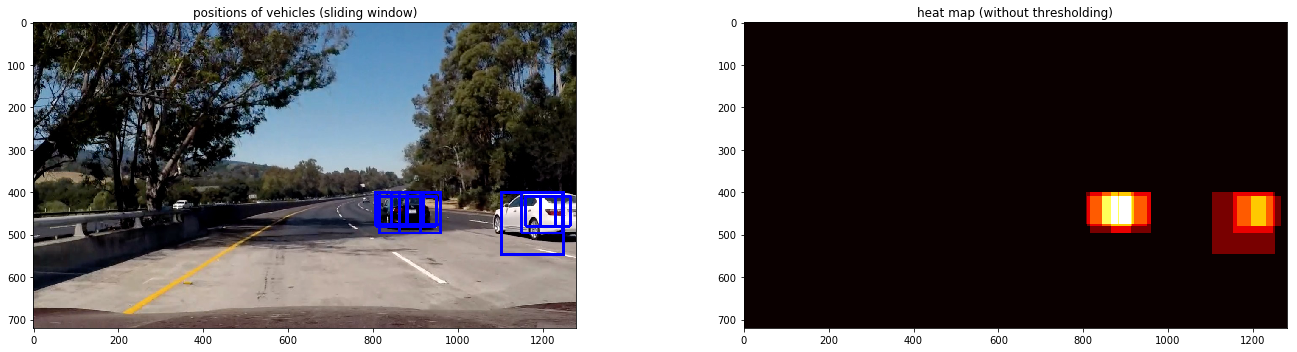

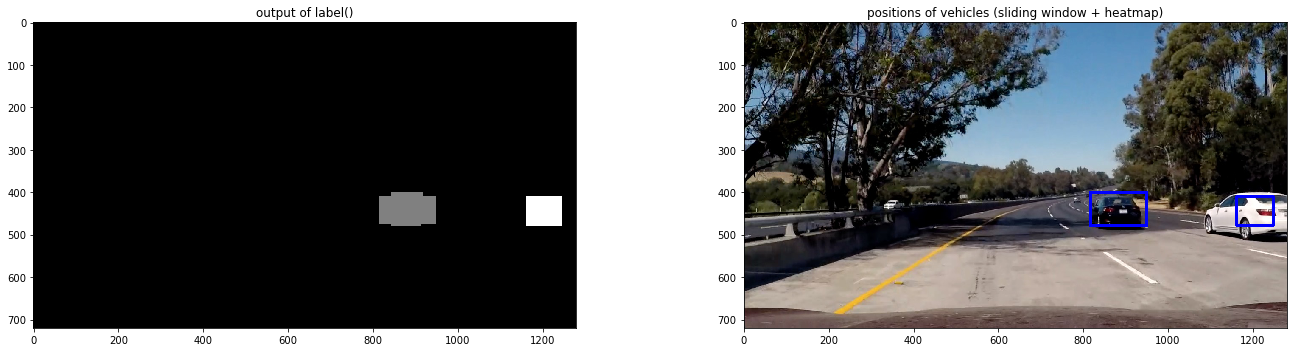

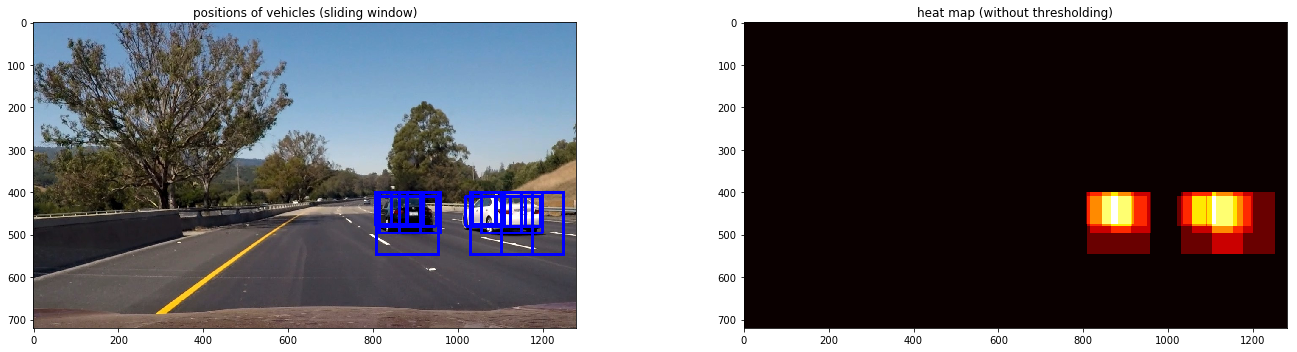

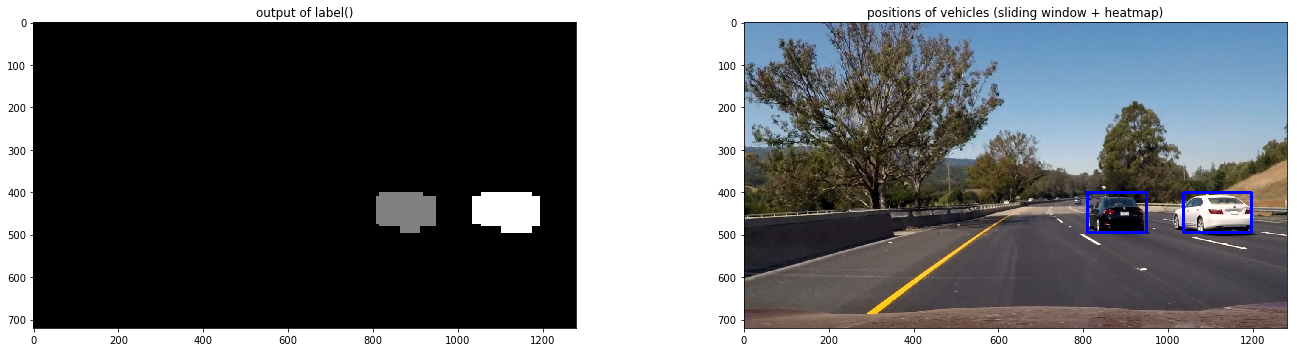

In [22]:
### Apply sliding window search + heat map to detect vehicles 

# threshold for heat map 
heat_threshold = 2.0

test_imgs_v = test_imgs
# # use below instead if one wants to create a image file for the write-up
# test_imgs_v = ['test_images/test4.jpg'] 

for test_img in test_imgs_v:
    img = mpimg.imread(test_img)
    box_list_total = []
    for ystart, ystop, scale, cells_per_step in param_find:
        box_list = find_vehicles(img, ystart=ystart, ystop=ystop, scale=scale, svc = svc, 
                                      X_scaler = X_scaler, orient = orient, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block, cells_per_step = cells_per_step, 
                                             spatial_size = spatial_size, hist_bins=hist_bins)
        box_list_total = box_list_total + box_list

    # image with boxes detected by the sliding window search
    out_img = draw_boxes(img, box_list_total)
    
    # create heatmap based on detected boxes and apply the threshold 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list_total)
    heat_th = apply_threshold(heat,threshold = heat_threshold)  
    heatmap = np.clip(heat_th, 0, 255) 
    
    # find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = np.copy(img)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    # plot images with final boxes and heatmap
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.imshow(out_img)
    plt.title('positions of vehicles (sliding window)')
    plt.subplot(122)
    plt.imshow(heat, cmap='hot')
    plt.title('heat map (without thresholding)')
    fig.tight_layout()
    # plt.savefig('output_images/heatmap_test4.jpg')
    plt.show()    
    
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.imshow(labels[0], cmap = 'gray')
    plt.title('output of label()')
    plt.subplot(122)
    plt.imshow(draw_img)
    plt.title('positions of vehicles (sliding window + heatmap)')
    fig.tight_layout()
    # plt.savefig('output_images/final_test4.jpg')
    plt.show()
    

### 3.3. Pipeline for Video 
By using the above, we define a function `pipeline_video()` which implements our pipeline for vehicle detection 
in the form applicable to videos. One improvement compared to the above case with a static image is that we used
the average values of the heat maps in past `20` time frames (the past heat maps are saved by using a class `record_heat` defined below) for the final vehicle detection. The implementation is given below: 

In [23]:
# a set of parameters for window search 
param_find = [(400, 500, 1.5, 2), (400, 480, 1.2, 2), (400, 620, 2.3, 2), (410, 500, 1.1, 2)]
# threshold for heat map 
heat_threshold = 2.0

class record_heat():
    """
    this class is used for storing the record of the heatmap in the previous time frames
    """
    def __init__(self):
        self.history = []
        self.hist_size = 20

def pipeline_video(image):
    """
    this function implements our pipeline for the vehicle detection 
    applicable to videos. 
    
    """
    img = image.copy()
    box_list_total = []
    for ystart, ystop, scale, cells_per_step in param_find:
        box_list = find_vehicles(img, ystart=ystart, ystop=ystop, scale=scale, svc = svc, 
                                      X_scaler = X_scaler, orient = orient, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block,cells_per_step = cells_per_step, 
                                             spatial_size = spatial_size, hist_bins=hist_bins)
        box_list_total = box_list_total + box_list

    # create heat map based on detected boxes
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list_total)
    
    # compute the average of the heat maps for several past time frames 
    record.history.append(heat)
    if len(record.history) > record.hist_size:
        record.history = record.history[1:]
    heat = sum(record.history)/len(record.history)
    
    heat = apply_threshold(heat,threshold = heat_threshold)  
    heatmap = np.clip(heat, 0, 255) 
    
        
    # final locations of the detected vehicles 
    labels = label(heatmap)
    draw_img = np.copy(img)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return draw_img

## 4. Performance 
Finally we apply our pipeline to videos to see its performance:

In [24]:
# ### for the test video `test_video.mp4`

# # for saving the info of previous time frames
# record = record_heat()

# video_name = 'videos/test_video.mp4'
# video = VideoFileClip(video_name)
# output = video.fl_image(pipeline_video)
# # output = video.fl_image(pipeline_video).subclip(0, 2) # use this when one wants to consider only a part of the video
# output.write_videofile('videos/test_output.mp4', audio=False)

In [25]:
### for the project video `project_video.mp4`

# for saving the info of previous time frames
record = record_heat()

video_name = 'videos/project_video.mp4'
video = VideoFileClip(video_name)
output = video.fl_image(pipeline_video)
# output = video.fl_image(pipeline_video).subclip(0, 15) # use this when one wants to consider only a part of the video
output.write_videofile('videos/project_output.mp4', audio=False)

[MoviePy] >>>> Building video videos/project_output.mp4
[MoviePy] Writing video videos/project_output.mp4


100%|█████████▉| 1260/1261 [10:55<00:00,  2.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_output.mp4 



NOTE: For the above evaluation, we used MacBook with 1.1 GHz Intel Core m3.